In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *


import scipy


In [2]:
PRE_INTERVAL = 1000
POST_INTERVAL = 1000
INTERVAL_SIZE = 100
SMOOTH = 1
EVENT = "StimOnset"
OUTPUT_DIR = "/data/patrick_res/hyak/pseudo"
# path to a dataframe of sessions to analyze

In [3]:
pairs = pd.read_pickle("/data/patrick_res/sessions/pairs_at_least_3blocks_10sess_fixed.pickle")

In [4]:
within_dim_accs = []
across_dim_accs = []
for (feat1, feat2) in pairs.pair.values:
    within_dim_acc = np.load(os.path.join(OUTPUT_DIR, f"ccgp_confidence_fixed_StimOnset_pair_{feat1}_{feat2}_within_dim_accs.npy"))
    across_dim_acc = np.load(os.path.join(OUTPUT_DIR, f"ccgp_confidence_fixed_StimOnset_pair_{feat1}_{feat2}_across_dim_accs.npy"))
    within_dim_accs.append(within_dim_acc)
    across_dim_accs.append(across_dim_acc)
within_dim_accs = np.hstack(within_dim_accs)
across_dim_accs = np.hstack(across_dim_accs)

Text(0, 0.5, 'Decoder Accuracy')

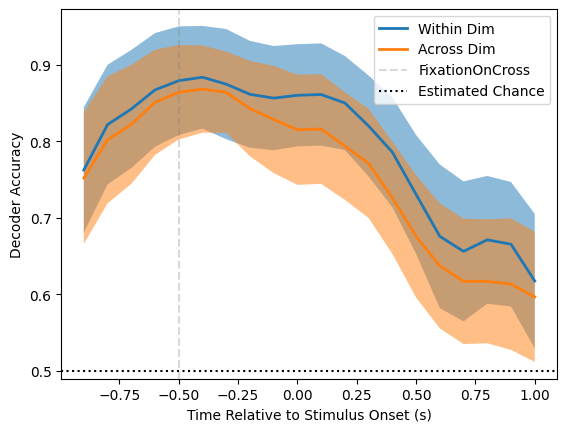

In [6]:
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    within_dim_accs,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"Within Dim",
    right_align=True, 
    # sem=True,
)
visualization_utils.visualize_accuracy_across_time_bins(
    across_dim_accs,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"Across Dim",
    right_align=True, 
    # sem=True,
)

# # add grey band for selection period
# ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
# # add dotted line for feedback start
ax.axvline(-0.5, alpha=0.3, color='gray', linestyle='dashed', label="FixationOnCross")
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_xlabel("Time Relative to Stimulus Onset (s)")
ax.set_ylabel("Decoder Accuracy")

### What about from the simulated firing rates?

In [6]:
within_dim_accs = np.empty((5, 160))
across_dim_accs = np.empty((5, 160))

for i, noise in enumerate([0.0, 0.1, 0.2, 0.3, 0.4]):
    within_dim_accs_noise = []
    across_dim_accs_noise = []
    for (feat1, feat2) in pairs.pair.values:
        within_dim_acc = np.load(os.path.join(OUTPUT_DIR, f"ccgp_confidence_simulation_noise_{noise}_pair_{feat1}_{feat2}_within_dim_accs.npy"))
        across_dim_acc = np.load(os.path.join(OUTPUT_DIR, f"ccgp_confidence_simulation_noise_{noise}_pair_{feat1}_{feat2}_across_dim_accs.npy"))
        within_dim_accs_noise.append(within_dim_acc)
        across_dim_accs_noise.append(across_dim_acc)
    within_dim_accs_noise = np.hstack(within_dim_accs_noise)
    across_dim_accs_noise = np.hstack(across_dim_accs_noise)
    within_dim_accs[i, :] = within_dim_accs_noise
    across_dim_accs[i, :] = across_dim_accs_noise


Text(0, 0.5, 'Decoder Accuracy')

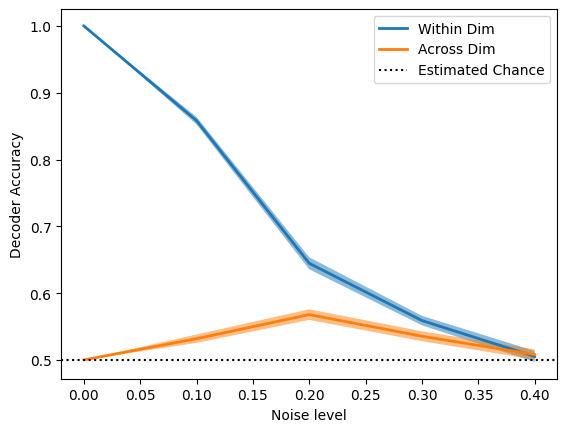

In [8]:
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    within_dim_accs,
    0, 0.5, 0.1,  # by default these are in seconds
    ax,
    label=f"Within Dim",
    # right_align=True, 
    sem=True,
)
visualization_utils.visualize_accuracy_across_time_bins(
    across_dim_accs,
    0, 0.5, 0.1,  # by default these are in seconds
    ax,
    label=f"Across Dim",
    # right_align=True, 
    sem=True,
)

# # add grey band for selection period
# ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
# # add dotted line for feedback start
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_xlabel("Noise level")
ax.set_ylabel("Decoder Accuracy")